## Загрузим нужные библиотеки

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

%matplotlib inline

In [218]:
df_orig = pd.read_csv("../data/train_dataset_train.csv")

/tmp/ipykernel_1615425/3617831425.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv("../data/train_dataset_train.csv")


In [252]:
def preprocess_dataframe(orig_df):
    df = orig_df.copy()
    df[['oper_type','oper_attr']] = df['oper_type + oper_attr'].astype(str).str.split("_", expand=True)
    df = df.drop(columns=['mailrank', 'oper_type + oper_attr'])
    print('split and drop done')

    categorical_columns = ['oper_type', 'oper_attr', 'priority', 'index_oper','type', 'class', 'mailtype', 'mailctg', 'directctg', 'postmark','is_wrong_sndr_name','is_wrong_rcpn_name', 'is_wrong_phone_number', 'is_wrong_address', 'is_privatecategory', 'is_in_yandex', 'is_return']
    for key in categorical_columns:
        df[key] = df[key].astype('category').cat.codes

    for key in ['total_qty_over_index_and_type', 'total_qty_over_index', 'total_qty_oper_login_0', 'total_qty_oper_login_1', 'dist_qty_oper_login_1', 'weight_mfi']:
        df[key] = df[key].astype(int)

    df['index_oper'] = df['index_oper'].astype(str).str.replace('.0','').astype('category').cat.codes

    categorical_columns += df.select_dtypes(include=['object']).columns.tolist()
    return df

# df = preprocess_dataframe(orig_df)

In [222]:
df.sample(10)

,id,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,...,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,oper_type,oper_attr
296092,6655767,5882,4,1,1,0,1,0,534.0,4,...,116432632,180702765,188407812,0,0,0,0,0,19,0
2151352,1635709,5882,4,1,1,0,1,0,87.0,4,...,83318932,132175590,136819803,0,0,1,0,0,6,0
3954141,4031909,9375,3,3,1,3,2,0,596.0,4,...,3998,26847,284505,0,0,0,0,0,17,0
4638680,111341,5882,4,1,1,0,1,0,1780.0,4,...,83318932,132175590,136819803,0,0,0,0,1,6,0
4915227,4579230,5850,4,1,1,0,1,0,119.0,4,...,83318932,132175590,136819803,0,0,0,0,0,19,0
4702249,8688895,5884,19,1,1,0,1,0,121.0,4,...,742718,3389705,3393369,0,0,0,0,0,16,0
2802432,5150767,16820,10,1,1,3,2,0,40.0,4,...,12480,47482,451353,0,1,0,0,0,55,1
5852096,4780719,19315,3,1,1,3,2,0,241.0,4,...,2838,9854,246359,0,1,0,0,0,17,0
4113570,1144098,5864,19,3,1,0,1,0,145.0,4,...,44785,7338902,25749199,0,0,0,0,0,19,0
5845300,6171853,14346,3,2,1,3,2,0,10.0,4,...,721,5067,87011,0,0,0,0,0,17,0


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   index_oper                     int16  
 2   type                           int8   
 3   priority                       int8   
 4   is_privatecategory             int8   
 5   class                          int8   
 6   is_in_yandex                   int8   
 7   is_return                      int8   
 8   weight                         float64
 9   mailtype                       int8   
 10  mailctg                        int8   
 11  directctg                      int8   
 12  transport_pay                  float64
 13  postmark                       int8   
 14  name_mfi                       object 
 15  weight_mfi                     int64  
 16  price_mfi                      float64
 17  dist_qty_oper_login_1          int64  
 18  to

In [224]:
df["label"].value_counts()

0    5829020
1     170980
Name: label, dtype: int64

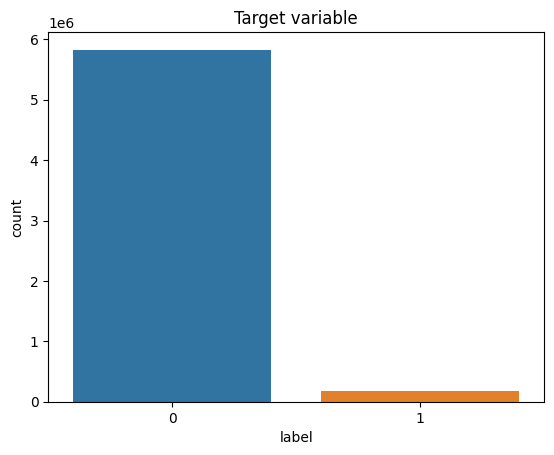

percentage of 0 and 1
 0    97.150333
1     2.849667
Name: label, dtype: float64


In [23]:
sns.countplot(data=df, x="label")
plt.title("Target variable")
plt.show()
print("percentage of 0 and 1\n",df["label"].value_counts()/len(df)*100)

Рассмотрим часть столбцов типа "object"

In [147]:
df.columns

Index(['id', 'oper_type + oper_attr', 'index_oper', 'type', 'priority',
       'is_privatecategory', 'class', 'is_in_yandex', 'is_return', 'weight',
       'mailtype', 'mailctg', 'directctg', 'transport_pay', 'postmark',
       'name_mfi', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1',
       'total_qty_oper_login_1', 'total_qty_oper_login_0',
       'total_qty_over_index_and_type', 'total_qty_over_index',
       'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number',
       'is_wrong_address', 'label', 'oper_type', 'oper_attr'],
      dtype='object')

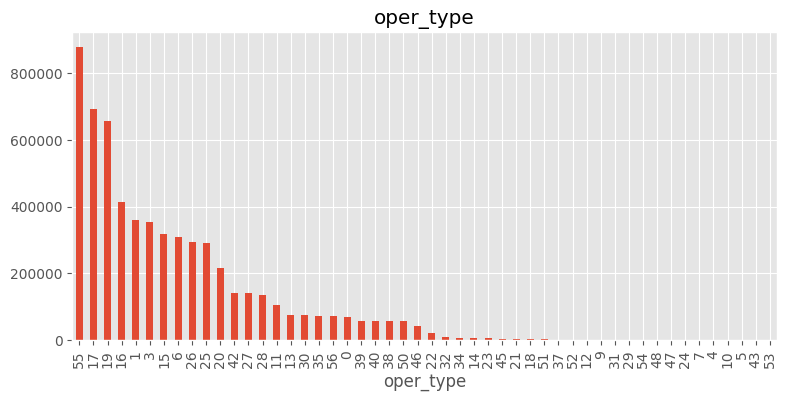

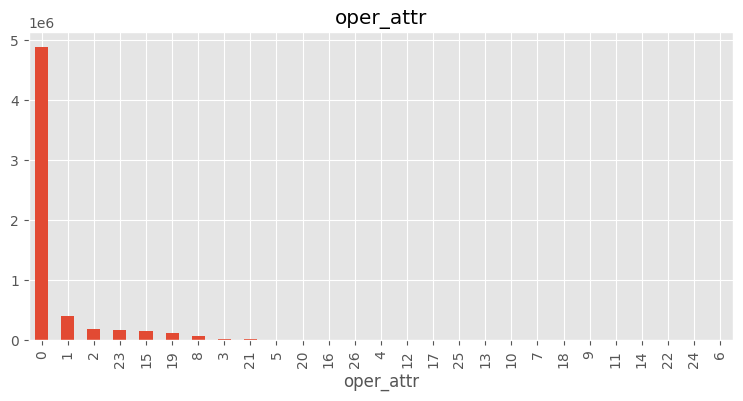

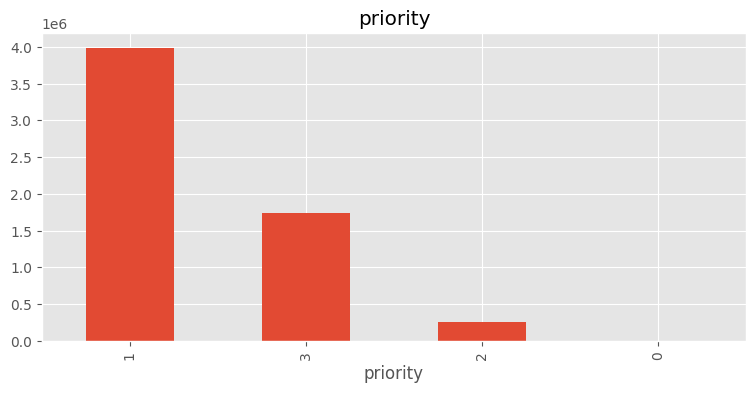

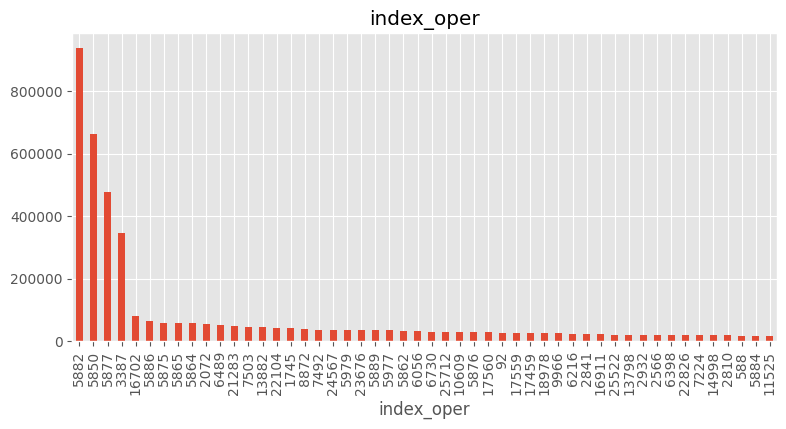

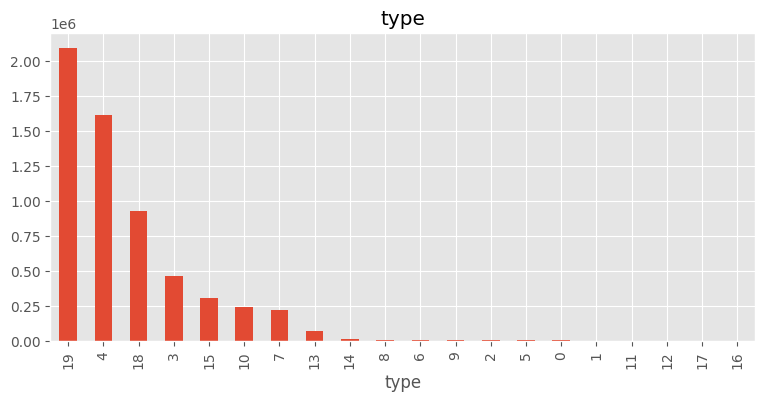

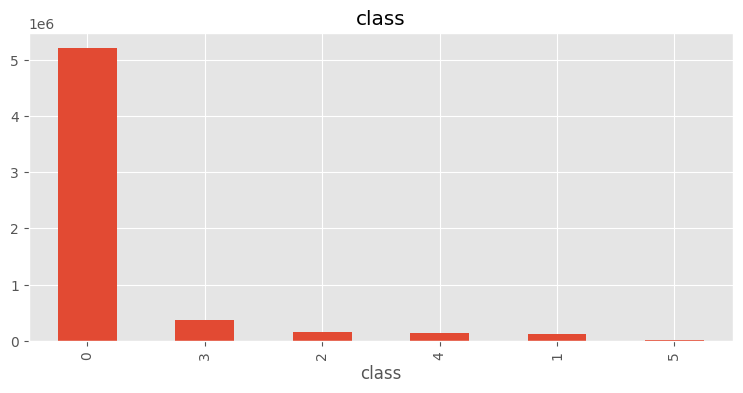

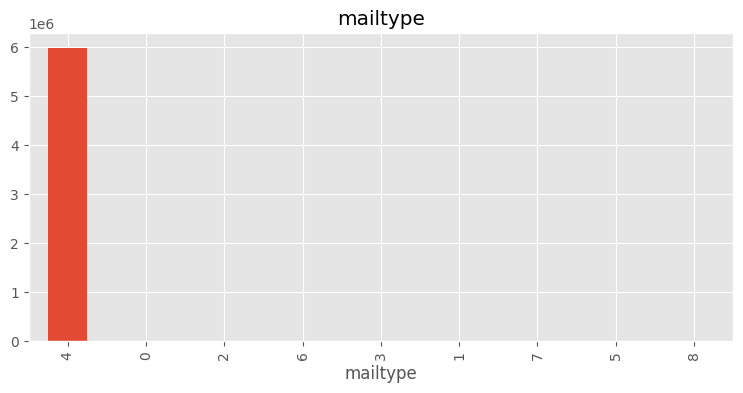

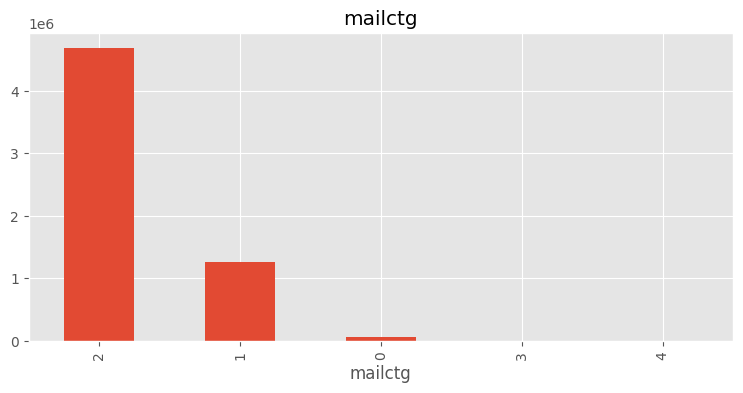

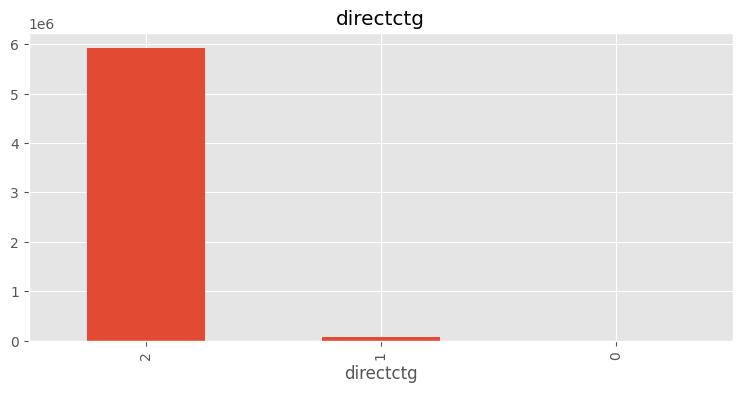

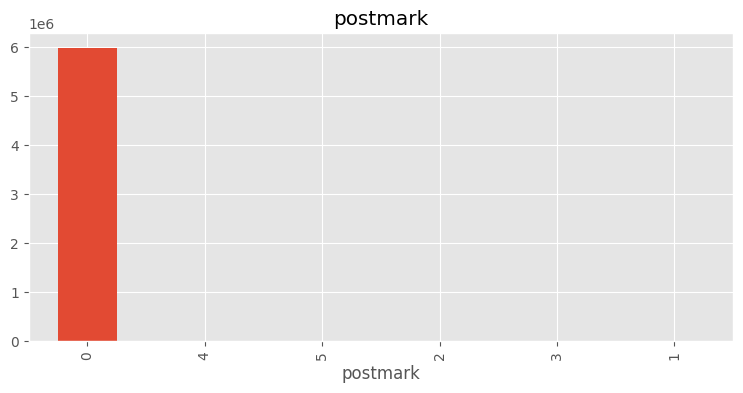

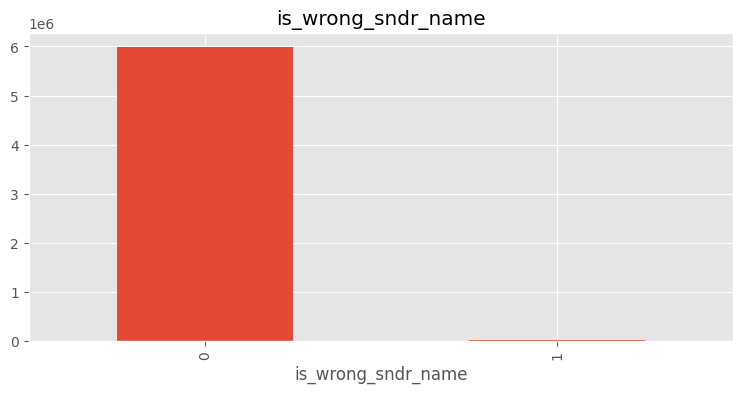

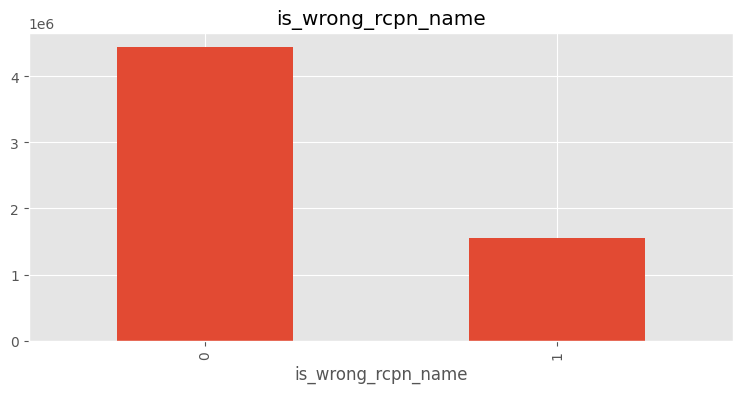

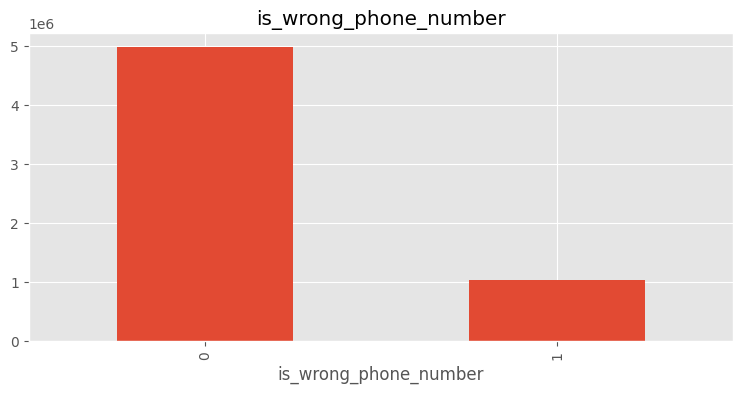

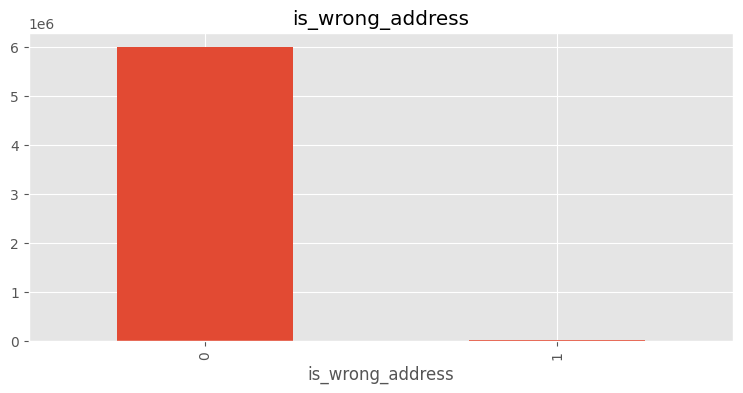

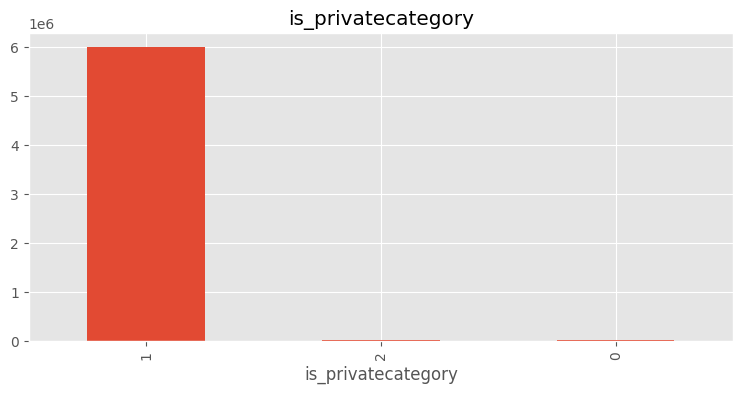

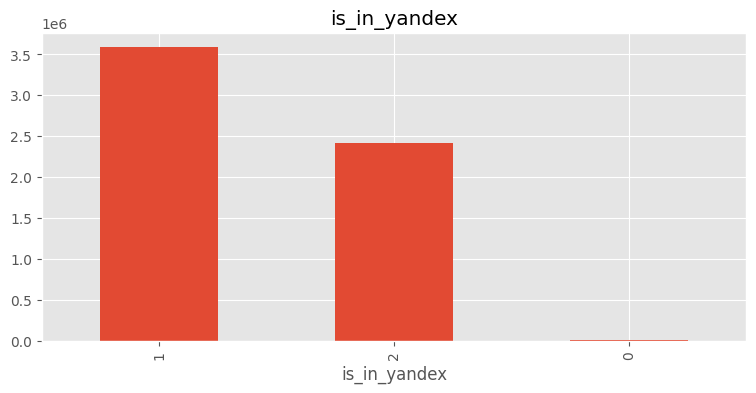

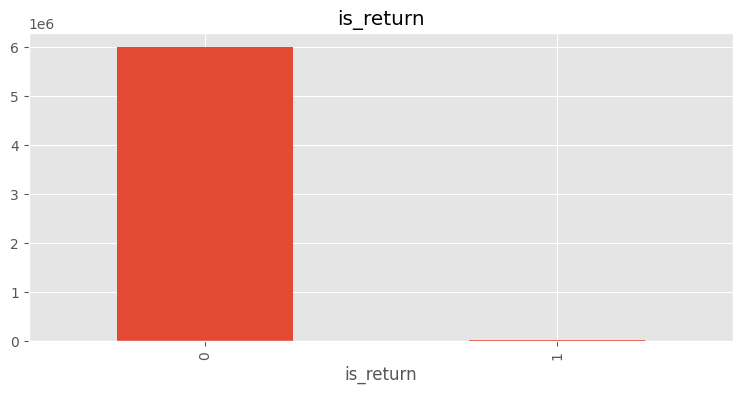

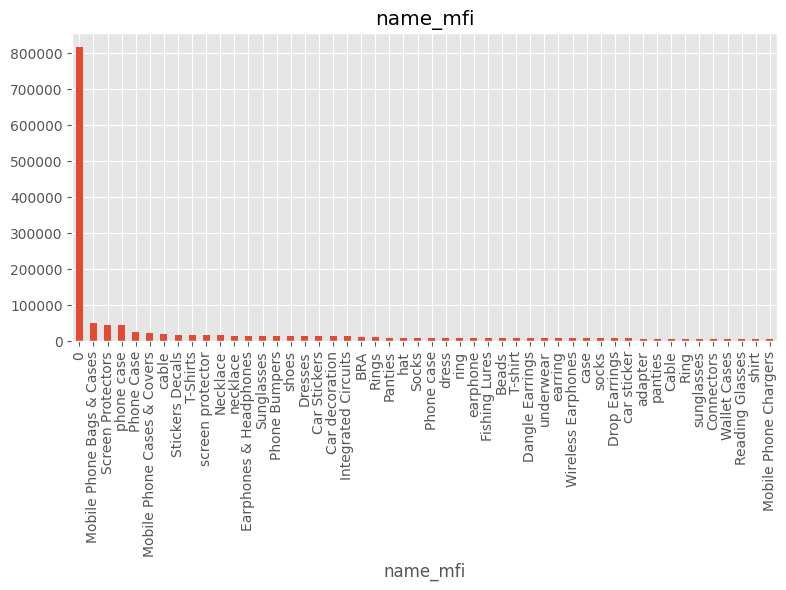

In [225]:
# indentifying the categorical variables
categorical_df= df.select_dtypes(include= [np.int8]).columns
# print(categorical_df)

# plotting bar chart for each categorical variable
plt.style.use("ggplot")

for column in categorical_columns:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    counts = df[column].value_counts()
    counts.head(50).plot(kind='bar')
    plt.xlabel(column)
#     plt.ylabel("number of customers")
    plt.title(column)
    plt.show()

In [228]:
numerical_columns = df.select_dtypes(include=np.float64)
numerical_columns.head()

,weight,transport_pay,price_mfi
0,87.0,0.00,150.0
1,107.0,0.00,400.0
2,50.0,0.00,218.0
3,416.0,35.34,100.0
4,795.0,52.52,1000.0


/tmp/ipykernel_1615425/623442639.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


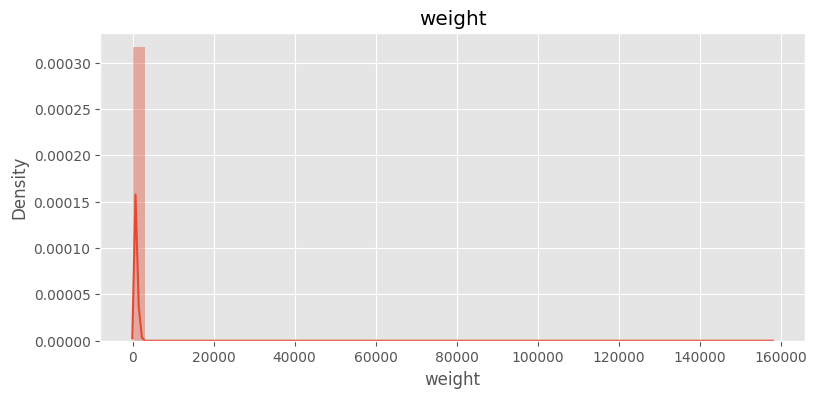

/tmp/ipykernel_1615425/623442639.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


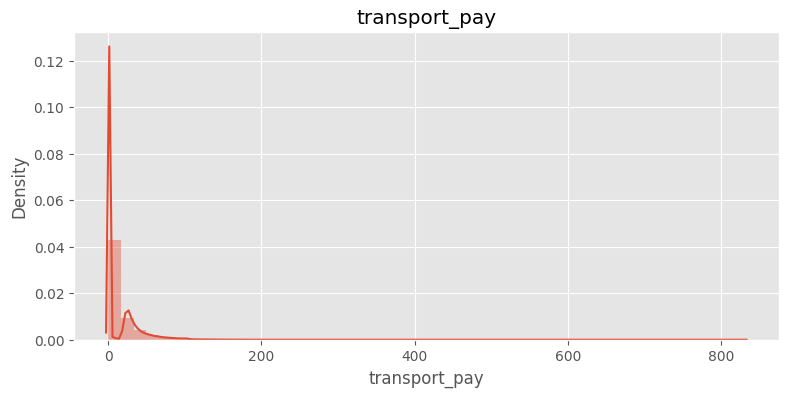

/tmp/ipykernel_1615425/623442639.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], kde=True)


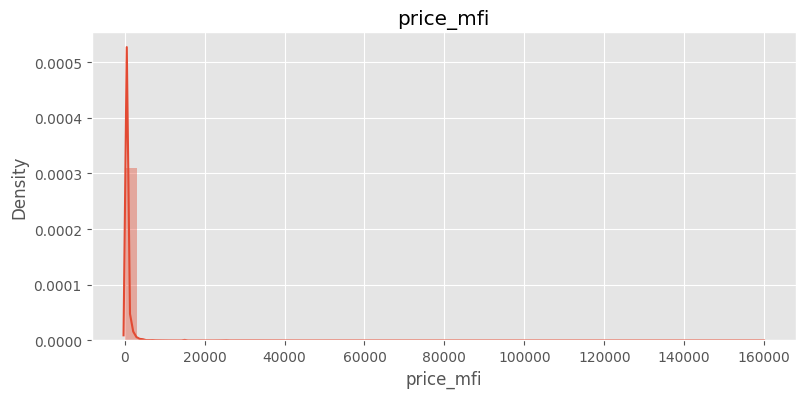

In [232]:
plt.style.use("ggplot")
for column in numerical_columns.columns:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(df[column], kde=True)
    plt.title(column)
    plt.show()

Посмотрим на некоторые столбцы

<AxesSubplot: xlabel='class', ylabel='count'>

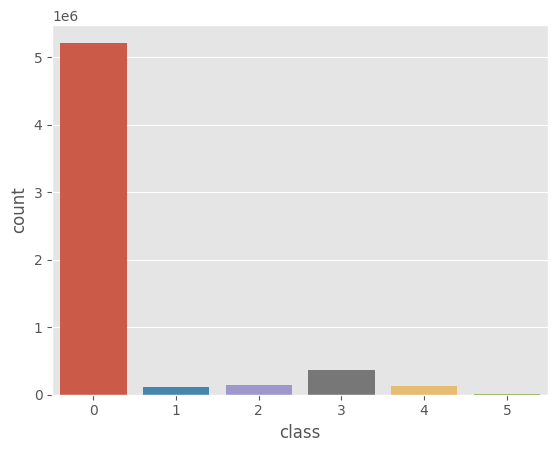

In [179]:
sns.countplot(x = "class" , data  = df) 

Псотроим матрицу корреляции значений

In [182]:
df.columns

Index(['id', 'oper_type + oper_attr', 'index_oper', 'type', 'priority',
       'is_privatecategory', 'class', 'is_in_yandex', 'is_return', 'weight',
       'mailtype', 'mailctg', 'directctg', 'transport_pay', 'postmark',
       'name_mfi', 'weight_mfi', 'price_mfi', 'dist_qty_oper_login_1',
       'total_qty_oper_login_1', 'total_qty_oper_login_0',
       'total_qty_over_index_and_type', 'total_qty_over_index',
       'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number',
       'is_wrong_address', 'label', 'oper_type', 'oper_attr'],
      dtype='object')

In [238]:
corr['index_oper']['total_qty_over_index_and_type']

-0.3611173463331229

/tmp/ipykernel_1615425/3097321424.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = subdf.corr()


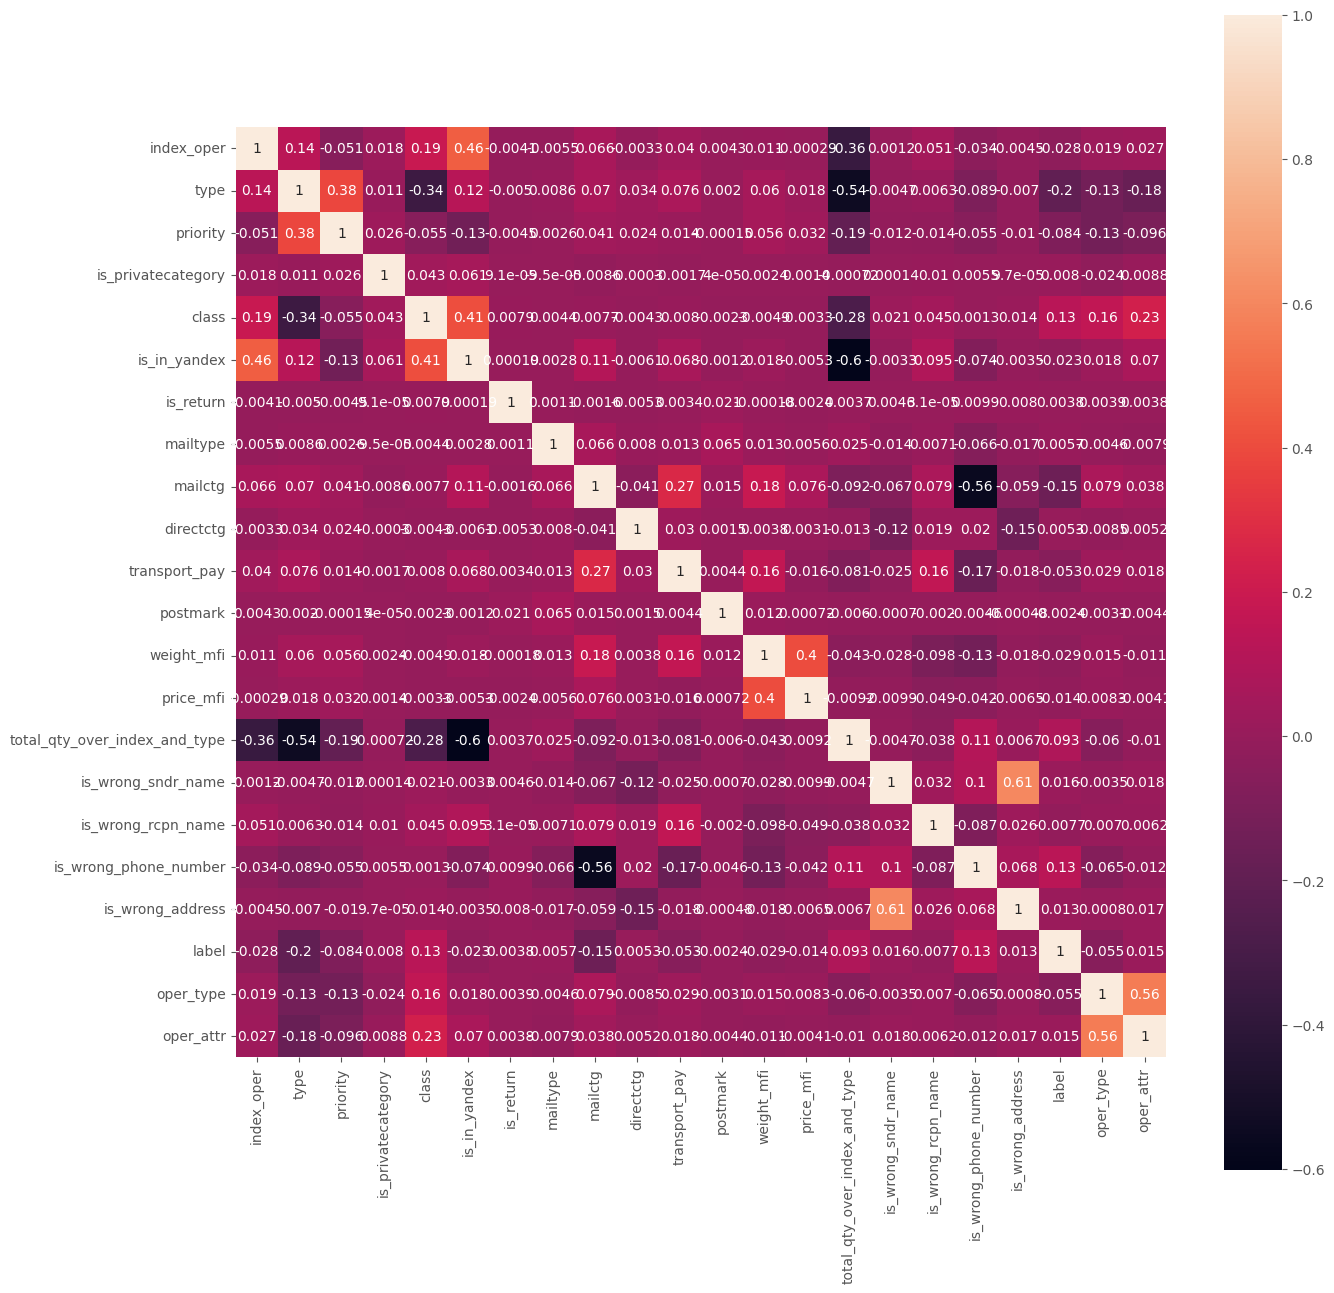

In [234]:
plt.rcParams['figure.figsize']=(15,15)

subdf = df.iloc[:100000].copy()
subdf = subdf.drop(columns=['id', 'weight', 'total_qty_over_index', 'total_qty_oper_login_0', 'total_qty_oper_login_1', 'dist_qty_oper_login_1'])
corr = subdf.corr()
g = sns.heatmap(corr, square = True, annot=True)

# Тестовая часть

In [314]:
df.drop(columns=['id']).sample(100,replace=False).duplicated().index

Int64Index([ 302255, 1179237, 5695011, 1780445, 1329298, 4488448, 5311562,
            1991153, 5454209, 5293773,  999659,  557838, 4383713, 4122316,
            1740307, 3802894, 4289499, 4614050, 3426003, 1805816, 5889921,
            4026982, 5443795, 2743198, 1458530, 2006072, 1773670, 5179195,
            3583100, 1691842,  653273,  291646, 2212371, 4427639, 1024392,
            3200244, 4993074, 1740697, 1521567, 2216527, 3386304, 4956729,
            2381650, 2551023, 4840642,  904072, 5223361, 4211806,   94933,
            4834745, 4675301, 1919615, 5344885, 3031175, 2033071, 2621845,
            4482568, 2846779, 3157427, 3672726,  970570, 1694287, 4033374,
            2122843,  619161, 5675480, 1443811, 3028650, 4154991, 4175533,
            4110801, 3925192, 3460772, 5631796, 4875617, 3814097, 1434597,
            2653675,  416089, 3920070, 2782655, 3119475, 4848971, 1743891,
            1166485, 3936340, 1008153, 1275202, 2577344,   61815, 2907456,
             972379, 2775

In [327]:
i_dups.index.values

array([5945570, 3075700, 1116957,  650241, 5506494,  943752, 5858253,
        986673, 2149983, 2602595,  758475, 1334915, 2466656, 5760541,
       5690486, 5217982,   22653,  183639, 4116002, 5960721, 4152622,
       5977450, 5270900, 4206164, 5683999,   52938, 2237294, 1834392,
       5939231, 2125044, 2080512, 3074191, 2711385, 4246312, 1897178,
        910917, 4881544, 5729122, 5099999, 2527643,  664977, 1318062,
        885508,  802369,  871444, 5495659, 2815771,  130635, 1226129,
       5748410, 1472101, 2423377,  482388, 3278918, 3675998,  828948,
       4784198, 4666228, 2856187,  541587,  587574, 5196456, 2597858,
       2653774, 5331798, 4271656, 4770752, 5568218, 3084803, 4238854,
       1619673,     761,  222816, 3232485, 5220576, 4742038, 2643687,
        690437, 1548941, 1318601, 2115839,  266533, 5329724, 3108721,
       5004559,  616850, 5409704, 1342823, 2901799, 3486924,  705776,
       5125417, 3220277, 4754726, 3682896, 3041767, 4493947, 3043108,
       3950828, 2027

In [ ]:
idups = df.drop(columns=['id']).sample(100000,replace=False).duplicated()
dups = df.iloc[idups.iloc[np.where(idups==True)].index.values]
dups.shape

In [298]:
col_dtypes={
    'class':np.uint8,
    'index_oper':str,
    'dist_qty_oper_login_1': int,
    'total_qty_oper_login_1': int,
    'total_qty_oper_login_0': int,
    'total_qty_over_index_and_type': int,
    'total_qty_over_index': int,
    'is_wrong_sndr_name': np.int8,
    'is_wrong_rcpn_name': np.int8,
    'is_wrong_phone_number': np.int8,
    'is_wrong_address': np.int8,
    'mailtype': np.int8,
    'mailctg': np.int8,
    'mailrank': np.int8,
    'directctg': np.int8,
    'postmark': int,
    'is_privatecategory': 'category',
    'is_in_yandex': 'category',
    'is_return': 'category',
    'type': 'category',
    'priority': 'category',
    
}

test_df = pd.read_csv('../data/test_dataset_test.csv',dtype=col_dtypes)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   id                             int64   
 1   oper_type + oper_attr          object  
 2   index_oper                     object  
 3   type                           category
 4   priority                       category
 5   is_privatecategory             category
 6   class                          uint8   
 7   is_in_yandex                   category
 8   is_return                      category
 9   weight                         float64 
 10  mailtype                       int8    
 11  mailctg                        int8    
 12  mailrank                       int8    
 13  directctg                      int8    
 14  transport_pay                  float64 
 15  postmark                       int64   
 16  name_mfi                       object  
 17  weight_mfi                 

In [299]:
test_df.describe()

,id,class,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4000000.0,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,5.001248e+06,3.570955e-01,2.399753e+02,4.995110e+00,7.731600e-01,0.0,1.988404e+00,1.187984e+01,9.705500e-02,1.237179e+02,4.556008e+02,3.189355e+02,2.773663e+07,2.897371e+07,5.671034e+07,7.177147e+07,2.582750e-03,2.597957e-01,1.707448e-01,1.236500e-03
std,2.887142e+06,9.855169e-01,3.967060e+02,1.554762e-01,4.403370e-01,0.0,1.073047e-01,2.224348e+01,7.640904e+00,2.093481e+02,2.115334e+03,4.011988e+02,2.903658e+07,5.333923e+07,7.290373e+07,7.509591e+07,5.075510e-02,4.385225e-01,3.762858e-01,3.514216e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.499771e+06,0.000000e+00,5.200000e+01,5.000000e+00,1.000000e+00,0.0,2.000000e+00,0.000000e+00,0.000000e+00,2.300000e+01,5.000000e+01,3.100000e+01,1.113748e+06,1.064800e+04,1.656011e+06,1.040204e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.000941e+06,0.000000e+00,1.050000e+02,5.000000e+00,1.000000e+00,0.0,2.000000e+00,0.000000e+00,0.000000e+00,6.000000e+01,1.920000e+02,1.130000e+02,9.570832e+06,3.664710e+05,1.393496e+07,5.270807e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.502303e+06,0.000000e+00,2.650000e+02,5.000000e+00,1.000000e+00,0.0,2.000000e+00,2.291000e+01,0.000000e+00,1.230000e+02,4.190000e+02,9.140000e+02,5.610820e+07,8.331893e+07,1.321756e+08,1.368198e+08,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,9.999998e+06,5.000000e+00,1.580000e+05,8.000000e+00,5.000000e+00,0.0,2.000000e+00,8.305000e+02,1.024000e+03,1.800000e+04,1.597050e+05,1.142000e+03,1.416888e+08,4.156581e+08,4.897385e+08,5.002511e+08,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [300]:
test_df.isna().sum()

id                               0
oper_type + oper_attr            0
index_oper                       0
type                             0
priority                         0
is_privatecategory               0
class                            0
is_in_yandex                     0
is_return                        0
weight                           0
mailtype                         0
mailctg                          0
mailrank                         0
directctg                        0
transport_pay                    0
postmark                         0
name_mfi                         0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
is_wrong_sndr_name               0
is_wrong_rcpn_name               0
is_wrong_phone_number            0
is_wrong_address                 0
dtype: int64

## Выделим выборки

In [52]:
df = df.fillna(0)

Обьединим список не нужных строк с списком строк типа object

In [242]:
col_obj = df.select_dtypes(include=['object']).columns.values
col_obj = list(set(col_obj) ^ set(["id", "label"]))

In [243]:
col_obj

['name_mfi', 'id', 'label']

In [244]:
X = df.drop(col_obj, axis = 1)
y = df[["label"]]

In [302]:
X['index_oper'].dtype

dtype('int16')

In [245]:
random_state = 3401
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=random_state)

## Обучение модели

In [247]:
clf = RandomForestClassifier(random_state=random_state, n_jobs=30)

In [248]:
clf.fit(X_train, y_train)

/tmp/ipykernel_1615425/2395142735.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(n_jobs=30, random_state=3401)

## Оценка точности

In [249]:
pred = clf.predict(X_test)

In [250]:
from sklearn.metrics import recall_score

score = recall_score(y_test, pred, average = "macro" )

In [251]:
print("Recall", score)

Recall 0.7779818610022927


In [254]:
sum(pred)

127564

In [253]:
test_df = pd.read_csv("../data/test_dataset_test.csv")
prep_df = preprocess_dataframe(test_df)

/tmp/ipykernel_1615425/385621094.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv("../data/test_dataset_test.csv")


split and drop done


/tmp/ipykernel_1615425/2507247033.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['index_oper'] = df['index_oper'].astype(str).str.replace('.0','').astype('category').cat.codes


In [261]:
X_inp = prep_df.drop(list(set(col_obj)-set(['label'])), axis = 1)

In [263]:
y_pred = clf.predict(X_inp)

In [264]:
y_pred.sum()

71045

In [268]:
submission = pd.DataFrame({'id':test_df['id'], 'label': y_pred})
submission.to_csv('../solutions/baseline_subset.csv', index=None)

In [283]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [12, 16, 18, 20],
    'n_estimators': [100, 200, 250, 300],
}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
search = GridSearchCV(rf, param_grid, n_jobs=30, cv=3, verbose=2)
# Fit the random search model
search.fit(X_train, y_train['label'].values)

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END .....bootstrap=True, max_depth=12, n_estimators=100; total time= 2.0min
[CV] END .....bootstrap=True, max_depth=18, n_estimators=250; total time= 5.2min
[CV] END ....bootstrap=False, max_depth=16, n_estimators=200; total time= 5.9min
[CV] END .....bootstrap=True, max_depth=12, n_estimators=250; total time= 5.2min
[CV] END ....bootstrap=False, max_depth=12, n_estimators=200; total time= 5.9min
[CV] END ....bootstrap=False, max_depth=20, n_estimators=100; total time= 2.2min
[CV] END .....bootstrap=True, max_depth=12, n_estimators=250; total time= 5.0min
[CV] END ....bootstrap=False, max_depth=12, n_estimators=200; total time= 5.9min
[CV] END ....bootstrap=False, max_depth=20, n_estimators=100; total time= 3.0min
[CV] END .....bootstrap=True, max_depth=12, n_estimators=100; total time= 2.0min
[CV] END .....bootstrap=True, max_depth=18, n_estimators=250; total time= 5.3min
[CV] END ....bootstrap=False, max_depth=16, n_es

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=30,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [12, 16, 18, 20],
                         'n_estimators': [100, 200, 250, 300]},
             verbose=2)

[CV] END .....bootstrap=True, max_depth=18, n_estimators=200; total time= 4.3min
[CV] END .....bootstrap=True, max_depth=20, n_estimators=300; total time= 6.2min
[CV] END ....bootstrap=False, max_depth=18, n_estimators=300; total time= 7.6min
[CV] END .....bootstrap=True, max_depth=18, n_estimators=200; total time= 4.3min
[CV] END .....bootstrap=True, max_depth=20, n_estimators=300; total time= 6.1min
[CV] END ....bootstrap=False, max_depth=18, n_estimators=300; total time= 7.7min
[CV] END .....bootstrap=True, max_depth=18, n_estimators=200; total time= 4.2min
[CV] END .....bootstrap=True, max_depth=20, n_estimators=300; total time= 6.2min
[CV] END ....bootstrap=False, max_depth=18, n_estimators=300; total time= 7.7min
[CV] END .....bootstrap=True, max_depth=16, n_estimators=250; total time= 5.3min
[CV] END ....bootstrap=False, max_depth=12, n_estimators=250; total time= 7.1min
[CV] END ....bootstrap=False, max_depth=20, n_estimators=250; total time= 5.9min
[CV] END .....bootstrap=True

In [284]:
search.best_score_

0.9816416666666666

In [288]:
X_train.shape

(600000, 26)

In [295]:
categorical_columns[-1]

'name_mfi'

In [294]:
for c in categorical_columns[:-1]:
    print(c, X_train[c].unique().shape)

oper_type (52,)
oper_attr (21,)
priority (4,)
index_oper (13760,)
type (20,)
class (6,)
mailtype (7,)
mailctg (5,)
directctg (3,)
postmark (6,)
is_wrong_sndr_name (2,)
is_wrong_rcpn_name (2,)
is_wrong_phone_number (2,)
is_wrong_address (2,)
is_privatecategory (3,)
is_in_yandex (3,)
is_return (2,)


In [297]:
list(set(categorical_columns) - set(['index_oper', 'name_mfi']))

['oper_type',
 'mailtype',
 'class',
 'is_wrong_sndr_name',
 'is_in_yandex',
 'priority',
 'directctg',
 'is_wrong_phone_number',
 'oper_attr',
 'is_return',
 'is_wrong_address',
 'type',
 'is_wrong_rcpn_name',
 'is_privatecategory',
 'postmark',
 'mailctg']

In [296]:
X_train_ohv = pd.get_dummies(X_train, columns=list(set(categorical_columns) - set(['index_oper', 'name_mfi'])))
X_train_ohv.shape

(600000, 150)

In [285]:
pred = search.best_estimator_.predict(X_test)

In [286]:
score = recall_score(y_test, pred, average = "macro" )

In [287]:
score

0.7767479502468895

In [280]:
search.best_params_, score

({'bootstrap': False, 'max_depth': 12, 'n_estimators': 200},
 0.7571024036252818)

In [282]:
y_pred = search.best_estimator_.predict(X_inp)
submission = pd.DataFrame({'id':test_df['id'], 'label': y_pred})
submission.to_csv('../solutions/baseline_subset_2.csv', index=None)